In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
from IPython.display import display, clear_output
import os 
from pathlib import Path
import uproot
import pandas as pd

In [2]:
from matplotlib.collections import LineCollection

def plot_physical_positions(coincidences_df: pd.DataFrame, ax=None):
    """
    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.
    
    For each coincidence pair, the two positions are plotted as small semi-transparent dots,
    and a semi-transparent red line is drawn connecting them. This version uses vectorized
    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting
    for large numbers of pairs.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,
            containing at least the columns:
                'PostPosition_X_1', 'PostPosition_Y_1',
                'PostPosition_X_2', 'PostPosition_Y_2'.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extract the arrays of coordinates.
    x1 = coincidences_df["PostPosition_X_1"].values
    y1 = coincidences_df["PostPosition_Y_1"].values
    x2 = coincidences_df["PostPosition_X_2"].values
    y2 = coincidences_df["PostPosition_Y_2"].values

    # Build an array of segments for the red lines.
    # Each segment is defined as [[x1, y1], [x2, y2]]
    segments = np.stack([np.column_stack((x1, y1)), np.column_stack((x2, y2))], axis=1)

    # Create a LineCollection from all segments.
    line_collection = LineCollection(segments, colors='white', linewidths=0.5, alpha=0.05)
    ax.add_collection(line_collection)

    # Plot all blue dots at once.
    ax.scatter(x1, y1, color='blue', s=20, alpha=0.5, zorder=3)
    ax.scatter(x2, y2, color='blue', s=20, alpha=0.5, zorder=3)

    ax.set_xlabel("PostPosition_X")
    ax.set_ylabel("PostPosition_Y")
    ax.set_facecolor("black")
    ax.set_title("Coincidence Pairs: Physical Positions")

    #plt.tight_layout()
    #plt.show()

In [3]:
#Reading in Sinogram Data

data = np.load("output/sinogram_data.npz")
sinogram = data["sinogram"]
theta_centers = data["theta_centers"]
r_edges = data["r_edges"]

print("Sinogram shape:", sinogram.shape)
print("Theta bins:", len(theta_centers))
print("R bins (from edges):", len(r_edges) - 1)


#Reading in Coincidences DF

coincidences_df = pd.read_csv("output/coincidences.csv")

Sinogram shape: (180, 180)
Theta bins: 180
R bins (from edges): 180


In [4]:
'''#Using a simualted phantom and sinogram

true_object = shepp_logan_phantom()
activity_level = 0.1
true_object = rescale(activity_level * true_object, 0.5)

#Forward project true object to generate simulated sinogram data 

azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles
sinogram = radon(true_object, azi_angles, circle=False)'''

'#Using a simualted phantom and sinogram\n\ntrue_object = shepp_logan_phantom()\nactivity_level = 0.1\ntrue_object = rescale(activity_level * true_object, 0.5)\n\n#Forward project true object to generate simulated sinogram data \n\nazi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles\nsinogram = radon(true_object, azi_angles, circle=False)'

(180, 180)


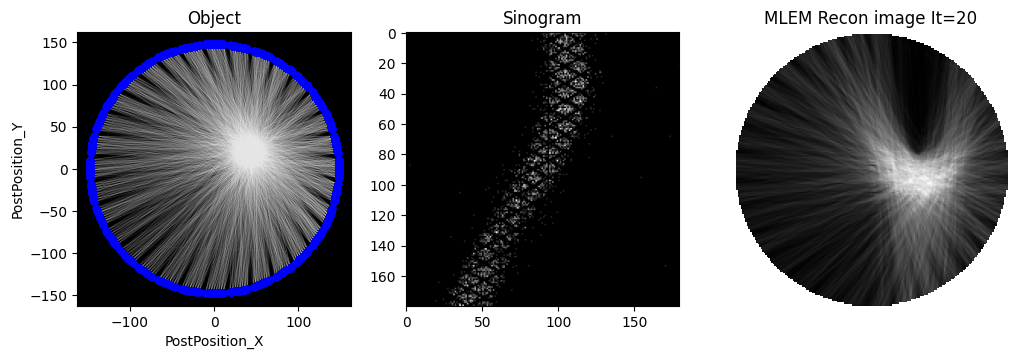

In [ ]:
#MLEM Reconstruction Using Sinogram Data

image_shape = (180, 180)
azi_angles = theta_centers

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
plot_physical_positions(coincidences_df, ax=axs[0])
axs[0].set_aspect('equal')  # forces x and y axis to have equal scaling
axs[0].autoscale(enable=True)
axs[0].set_title('Object')


axs[1].imshow(sinogram.T, cmap="Greys_r") #transpose of sinogram so angle is on y-axis
axs[1].set_title("Sinogram")

#Define reconstructed image
mlem_rec = np.ones(sinogram.shape) #(x^k), iteration 0 (k=0)
print(mlem_rec.shape)
#mask = np.zeros(true_object.shape, dtype=bool)
#rr, cc = disk((true_object[0] // 2, true_object[1] // 2), true_object[0] // 2)
#mask[rr, cc] = True
#mlem_rec *= mask

for iter in range(20):  
    fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
    print(fp.shape)
    ratio = sinogram / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
    correction = iradon(ratio, azi_angles, circle=True , filter_name=None) / sens_image # No filter because we are just getting the transpose A^T

    #axs[2].imshow(mlem_rec, cmap="Greys_r")
    axs[2].set_title("MLEM recon")

    mlem_rec = mlem_rec * correction

    extent = [
    -image_shape[1] // 2,
    image_shape[1] // 2,
    -image_shape[0] // 2,
    image_shape[0] // 2,
    ]

    axs[2].imshow(mlem_rec, cmap="Greys_r", extent=extent)

    axs[2].set_title("MLEM Recon image It=%d" % (iter+1))
    axs[2].axis('off')
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)
